In [1]:
# Setup 
from pathlib import Path
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from stargazer.stargazer import Stargazer 
from IPython.core.display import HTML
from zipfile import ZipFile 
from io import BytesIO 
import requests

heatmap_py_url = "https://raw.githubusercontent.com/aezarebski/aas-extended-examples/main/example-2.5/heatmap.py"
req = requests.get(heatmap_py_url)

with open("urlheatmap.py", "w") as f:
    f.write(req.text)
    
from urlheatmap import correlation_heatmap

In [2]:
# Wrangling
datadir = Path().cwd().parent/"Stats"

vaccine = pd.read_csv(datadir/ "covid-vaccine.csv")
vaccine = vaccine.groupby("Code").last()
vaccine.reset_index(inplace=True)
vaccine["Total_Hesitant"] = vaccine["uncertain_covid_vaccinate_this_week_pct_pop"] + vaccine["unwillingness_covid_vaccinate_this_week_pct_pop"]
vaccine_sum= vaccine[["Code","Entity","Total_Hesitant"]]

url = "http://digitalsocietyproject.org/wp-content/uploads/2021/04/DigitalSocietyProject-v3-CSV.zip"
filename = requests.get(url).content
zf = ZipFile( BytesIO(filename), "r" )
match = [s for s in zf.namelist() if "csv" in s][0]
information = pd.read_csv(zf.open(match), encoding = "latin-1")
information = information[information["year"] == 2020]
information = information[["country_name","country_text_id","v2smgovdom","v2smpardom","v2smfordom", "v2smforads"]]
for col in ["v2smfordom","v2smgovdom","v2smpardom", "v2smforads"]:
    information[col] = information[col].astype(np.float64)

In [3]:
# Table 1
information.describe()

,v2smgovdom,v2smpardom,v2smfordom,v2smforads
count,179.000000,179.000000,179.000000,179.000000
mean,-0.110257,-0.288162,-0.053799,-0.187844
std,1.483532,1.199373,1.245655,1.177588
min,-3.456000,-3.534000,-4.271000,-3.813000
25%,-1.206000,-1.133000,-0.979000,-0.880000
50%,-0.199000,-0.225000,0.086000,-0.146000
75%,0.984500,0.629500,0.794500,0.612000
max,2.873000,2.812000,2.543000,2.442000


In [4]:
# Table 2
vaccine["Total_Hesitant"].describe()

count    15.000000
mean     20.435333
std       4.478742
min      14.350000
25%      17.360000
50%      20.290000
75%      22.800000
max      30.370000
Name: Total_Hesitant, dtype: float64

In [5]:
# Table 3
merged=pd.merge(vaccine[["Code","Entity","Total_Hesitant"]], information, how='left', left_on=["Code"],right_on=["country_text_id"])
merged.drop(["country_name","country_text_id"],axis=1,inplace=True)
    
form_1 = "Total_Hesitant ~ v2smfordom"
fit_1 = smf.ols(formula = form_1, data = merged).fit()

form_2 = "Total_Hesitant ~ v2smfordom + v2smpardom"
fit_2 = smf.ols(formula = form_2, data = merged).fit()

form_3 = "Total_Hesitant ~ v2smfordom + v2smgovdom + v2smpardom + v2smforads"
fit_3 = smf.ols(formula = form_3, data = merged).fit()

stargazer = Stargazer([fit_1,fit_2,fit_3])
HTML(stargazer.render_html())

In [6]:
# Table 6 (Appendix C)
table_6= vaccine.drop(columns=["Code"]).rename(columns={"Entity":"Country","people_vaccinated_per_hundred":"People vaccinated (%)","willingness_covid_vaccinate_this_week_pct_pop":"Willing (%)",
                                                           "uncertain_covid_vaccinate_this_week_pct_pop":"Uncertain (%)","unwillingness_covid_vaccinate_this_week_pct_pop":"Unwilling (%)","Total_Hesitant":"Total Hesitant (%)"})
                                                          

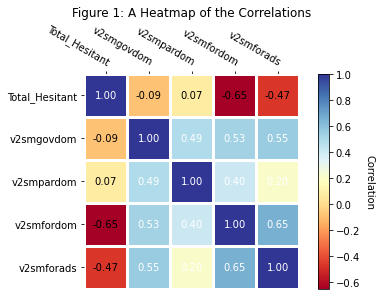

In [7]:
# Figure 1
col_names = merged.columns.to_list()
numeric_cols = col_names[2:] 
correlation_heatmap(merged[numeric_cols])
plt.title("Figure 1: A Heatmap of the Correlations")
plt.show()

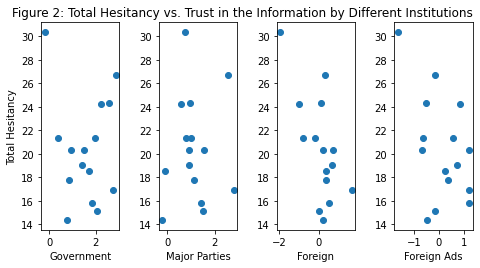

In [8]:
# Figure 2
plt.subplot(141)
plt.scatter(merged["v2smgovdom"],merged["Total_Hesitant"])
plt.xlabel('Government')
plt.ylabel('Total Hesitancy')

plt.subplot(142)
plt.scatter(merged["v2smpardom"],merged["Total_Hesitant"])
plt.xlabel('Major Parties')

plt.subplot(143)
plt.scatter(merged["v2smfordom"],merged["Total_Hesitant"])
plt.xlabel('Foreign')

plt.subplot(144)
plt.scatter(merged["v2smforads"],merged["Total_Hesitant"])
plt.xlabel('Foreign Ads')

plt.subplots_adjust(top=0.8, bottom=0.08, left=0.0, right=1.0, hspace=0.5, wspace=0.5)
plt.title("Figure 2: Total Hesitancy vs. Trust in the Information by Different Institutions",loc='right')
plt.show()

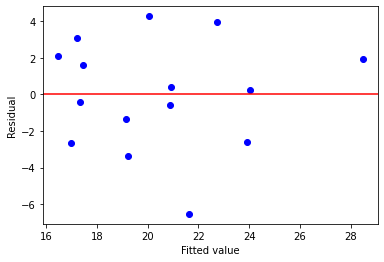

In [9]:
# Figure 3
def make_fittedvalues_resid_plot(fit):
    plt.figure()
    plt.scatter(fit.fittedvalues, fit.resid, color='b')
    plt.axhline(y=0, color='r')
    plt.xlabel("Fitted value")
    plt.ylabel("Residual")
    return

make_fittedvalues_resid_plot(fit_2)
plt.show()